# 선형회귀 Linear Regression
* **1, 2학기 전체**로 y = 각 시간별 주문 합계를 확인

### 라이브러리 임포트

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
import pickle

### data 불러오기

In [2]:
df = pd.read_excel("../resource/final_for_models.xlsx")
df.head()

,일자,semester,season,event,day of the week,time,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34


In [3]:
df = df.rename(columns = {'day of the week' : '요일', 'season' : '계절', 'semester' : '학기', 'time': 'hour'})   # 보기 편하게 열 이름 rename
df

,일자,학기,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34
...,...,...,...,...,...,...,...,...,...,...,...
1471,2022-12-21,2,11,2,2,13,0.3,0.8,0.0,89,40
1472,2022-12-21,2,11,2,2,14,0.6,1.0,0.0,88,39
1473,2022-12-21,2,11,2,2,15,2.0,0.1,0.0,83,22
1474,2022-12-21,2,11,2,2,16,0.7,0.5,0.0,89,27


## Regression 모델에 맞게 데이터 전처리

#### Categorical 데이터들을 Regression 모델이 이해할 수 있는 **One-Hot Encoding**을 통해 binary data로 변환

In [4]:
# one-hot encoding을 위해, 숫자형으로 바꿨던 것을 다시 범주형으로 바꿔줌
# (기존에 정의한 함수 mapping 사용)

from model_prep.onehotmap import *

df = map_season(df, '계절')
df = map_event(df, 'event')
df = map_day(df, '요일')
df = map_hour(df, 'hour')

df.head()  # 바뀐 df 확인

,일자,학기,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,봄,평소,수요일,8시,-2.9,0.6,0.0,78,15
1,2022-03-02,1,봄,평소,수요일,9시,0.4,1.2,0.0,59,12
2,2022-03-02,1,봄,평소,수요일,10시,3.6,0.3,0.0,47,18
3,2022-03-02,1,봄,평소,수요일,11시,5.2,1.3,0.0,42,39
4,2022-03-02,1,봄,평소,수요일,12시,6.8,1.2,0.0,27,34


In [5]:
# '계절', 'event', '요일'에 대해 one-hot encoding 수행
data_encoded = pd.get_dummies(df, columns=['계절', 'event', '요일', 'hour'])

data_encoded   # one-hot encoding 잘됐는지 확인

,일자,학기,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,계절_가을,계절_겨울,계절_봄,...,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,hour_17시,hour_8시,hour_9시
0,2022-03-02,1,-2.9,0.6,0.0,78,15,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,2022-03-02,1,0.4,1.2,0.0,59,12,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,2022-03-02,1,3.6,0.3,0.0,47,18,False,False,True,...,True,False,False,False,False,False,False,False,False,False
3,2022-03-02,1,5.2,1.3,0.0,42,39,False,False,True,...,False,True,False,False,False,False,False,False,False,False
4,2022-03-02,1,6.8,1.2,0.0,27,34,False,False,True,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2022-12-21,2,0.3,0.8,0.0,89,40,False,True,False,...,False,False,False,True,False,False,False,False,False,False
1472,2022-12-21,2,0.6,1.0,0.0,88,39,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1473,2022-12-21,2,2.0,0.1,0.0,83,22,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1474,2022-12-21,2,0.7,0.5,0.0,89,27,False,True,False,...,False,False,False,False,False,False,True,False,False,False


#### 일자 없애기
* regression에선 datetime 데이터 타입을 받을 수 없기 때문에 진행해줘야 함
* 슬라이싱 진행

In [6]:
data = data_encoded.iloc[:, 1:]
data

,학기,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,계절_가을,계절_겨울,계절_봄,계절_여름,...,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,hour_17시,hour_8시,hour_9시
0,1,-2.9,0.6,0.0,78,15,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,1,0.4,1.2,0.0,59,12,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,1,3.6,0.3,0.0,47,18,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
3,1,5.2,1.3,0.0,42,39,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False
4,1,6.8,1.2,0.0,27,34,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2,0.3,0.8,0.0,89,40,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1472,2,0.6,1.0,0.0,88,39,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1473,2,2.0,0.1,0.0,83,22,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
1474,2,0.7,0.5,0.0,89,27,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


#### 데이터프레임 보기 좋게 정렬

In [7]:
data.columns    # 해당 데이터프레임의 columns가 뭐가 있는지 확인하기 위함

Index(['학기', '기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', '합계', '계절_가을', '계절_겨울',
       '계절_봄', '계절_여름', 'event_보강주', 'event_시험', 'event_축제', 'event_평소',
       '요일_금요일', '요일_목요일', '요일_수요일', '요일_월요일', '요일_화요일', 'hour_10시',
       'hour_11시', 'hour_12시', 'hour_13시', 'hour_14시', 'hour_15시', 'hour_16시',
       'hour_17시', 'hour_8시', 'hour_9시'],
      dtype='object')

In [8]:
# 보기 쉬운 열 정렬로 직접 정렬해줌

data = data[['학기', 'hour_8시', 'hour_9시', 'hour_10시', 'hour_11시', 'hour_12시', 
             'hour_13시', 'hour_14시', 'hour_15시', 'hour_16시', 'hour_17시', 
             '계절_봄', '계절_여름', '계절_가을', '계절_겨울', 
             'event_보강주', 'event_시험', 'event_축제', 'event_평소', 
             '요일_월요일', '요일_화요일', '요일_수요일', '요일_목요일', '요일_금요일', 
             '기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', '합계']]

data.head()  # 정렬 모습 확인

,학기,hour_8시,hour_9시,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,...,요일_월요일,요일_화요일,요일_수요일,요일_목요일,요일_금요일,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,1,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,-2.9,0.6,0.0,78,15
1,1,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,0.4,1.2,0.0,59,12
2,1,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,3.6,0.3,0.0,47,18
3,1,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,5.2,1.3,0.0,42,39
4,1,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,6.8,1.2,0.0,27,34


In [9]:
# one-hot encoding을 진행해줬던 열들의 이름이 '(one-hot encode 당한 열의 이름)_(해당 열의 속성값)'으로 구성되어있음
# 가독성을 위해, '(해당 열의 속성값)'만 남겨두고 언더바부터 앞의 문자까지 삭제해주는 전처리 진행

# 미리 지정해둔 함수를 통해 전처리
from model_prep.dfrename import *

check = rename_columns(data)
check.head()

,학기,8시,9시,10시,11시,12시,13시,14시,15시,16시,...,월요일,화요일,수요일,목요일,금요일,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,1,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,-2.9,0.6,0.0,78,15
1,1,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,0.4,1.2,0.0,59,12
2,1,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,3.6,0.3,0.0,47,18
3,1,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,5.2,1.3,0.0,42,39
4,1,False,False,False,False,True,False,False,False,False,...,False,False,True,False,False,6.8,1.2,0.0,27,34


## Regression 전, 변수들의 correlation 분석
* **히트맵**을 사용해 **상관관계**를 시각화

c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 48388 (\N{HANGUL SYLLABLE BOM}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 47492 (\N{HANGUL SYLLABLE REUM}) missing from current font.
  fig.canvas.draw()
c:\Users\sohtk\anaconda3\Lib\

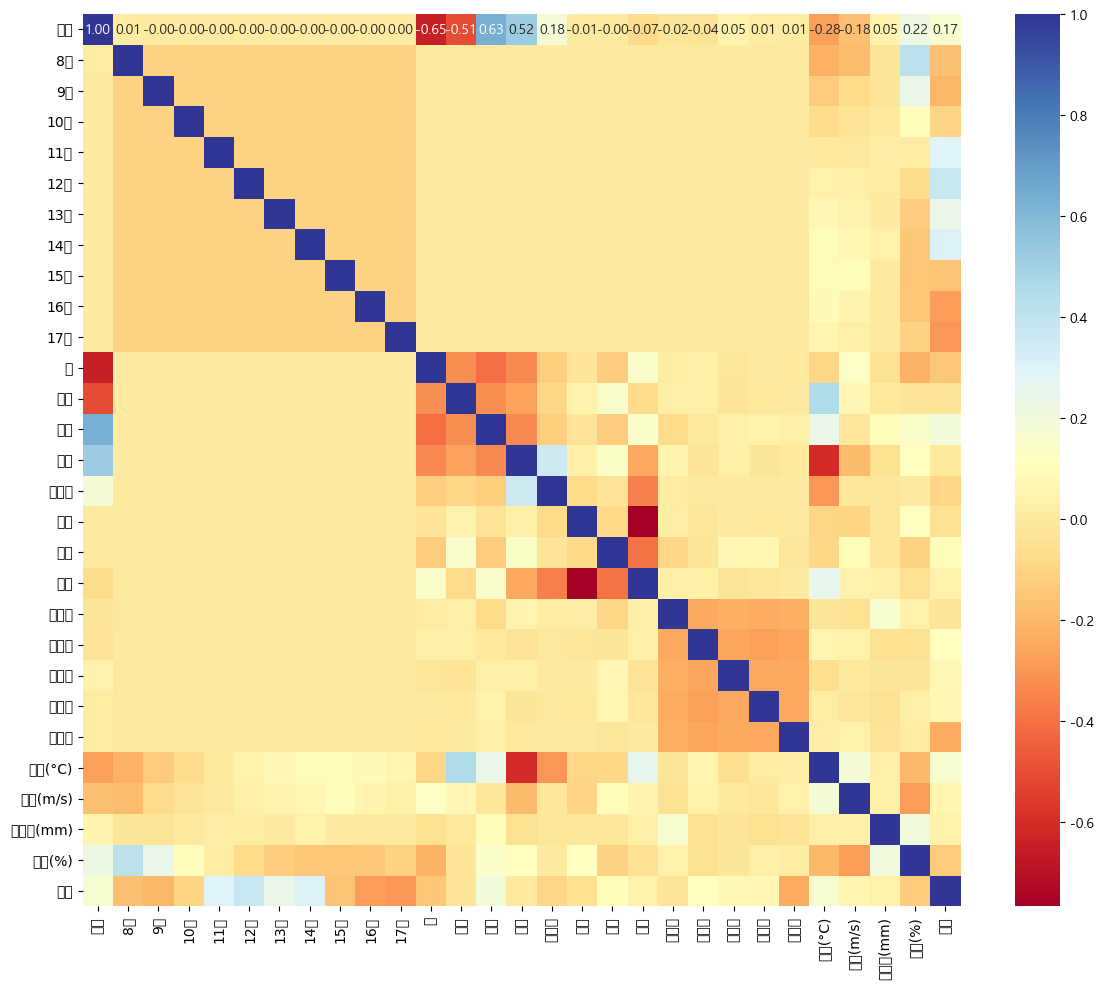

In [10]:
# 미리 지정해둔 함수를 통해 히트맵으로 시각화
from vis.corrvis import corr_heatmap

corr = data.corr(method = 'pearson')
cols = list(data.columns)
corr_heatmap(corr, cols)

## Linear Regression 진행

#### X와 y 지정

In [11]:
num_cols = cols
num_cols.remove('합계')   # 데이터프레임 전체의 columns를 리스트로 받아왔었기 때문에, y로 들어갈 '합계'를 제거

X = data[num_cols]
y = data["합계"]

### Linear Regression Experiment
1. **임의로 랜덤**하게 test셋과 train셋을 나눔
* **각 변수가 얼만큼 영향**을 미치는지 확인 _(= 가중치 뽑기)_ 해보기 위해 진행

In [12]:
train_input, test_input, train_target, test_target = train_test_split(X, y, random_state=42)
# random_state: 호출할 때마다 동일한 train/test dataset을 생성하기 위해 주어지는 parameter

In [13]:
# linear regression 모델 호출 및 fit

lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

In [14]:
# coef_ = 가중치 리스트, intercept_ = 회귀식의 상수

print(lr.coef_, lr.intercept_)

[  5.60636092  -8.46000129 -11.72216902  -6.02367779  21.62264888
  25.4471101   16.87057844  20.66062666 -13.58544135 -22.07132045
 -22.73835417  -3.29880594  -2.30755498   4.45019921   1.1561617
 -11.58621829  -1.0363997   11.77666052   0.84595747  -0.03336262
   5.2981944    3.04926778   3.51579964 -11.8298992    0.34460369
   0.70449555   0.29993791  -0.08321718] 26.753836107872004


* 학습시킨 모델의 지표를 확인

In [15]:
# test set으로 예측
pred_test = lr.predict(test_input)  # X_test 데이터를 예측한 결과 저장

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평가 지표 계산
mae = mean_absolute_error(test_target, pred_test)
mse = mean_squared_error(test_target, pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, pred_test)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

Mean Absolute Error (MAE): 9.98669978692423
Mean Squared Error (MSE): 172.4982245405319
Root Mean Squared Error (RMSE): 13.133857945802974
R-squared: 0.7160242931796377


#### 각 변수들의 **가중치** 확인
* 해당 모델의 가중치를 dataframe에 넣음

In [17]:
### "feature - coefficients" DataFrame 만들기
coefs = pd.DataFrame(zip(data[num_cols].columns, lr.coef_), columns = ['feature', 'coefficients'])

# 절댓값을 기준으로 정렬하기 위한 임시 열 추가
coefs['abs_coef'] = coefs['coefficients'].abs()

# 'abs_coef' 열을 기준으로 오름차순 정렬
# 오름차순 정렬을 해야, 시각화했을 때 가장 영향을 많이 주는 것이 가장 위로 보이며 시각화가 됨
coefs.sort_values(by='abs_coef', inplace=True)

coefs.head(7)   # 확인

,feature,coefficients,abs_coef
19,월요일,-0.033363,0.033363
27,습도(%),-0.083217,0.083217
26,강수량(mm),0.299938,0.299938
24,기온(°C),0.344604,0.344604
25,풍속(m/s),0.704496,0.704496
18,평소,0.845957,0.845957
16,시험,-1.036400,1.036400


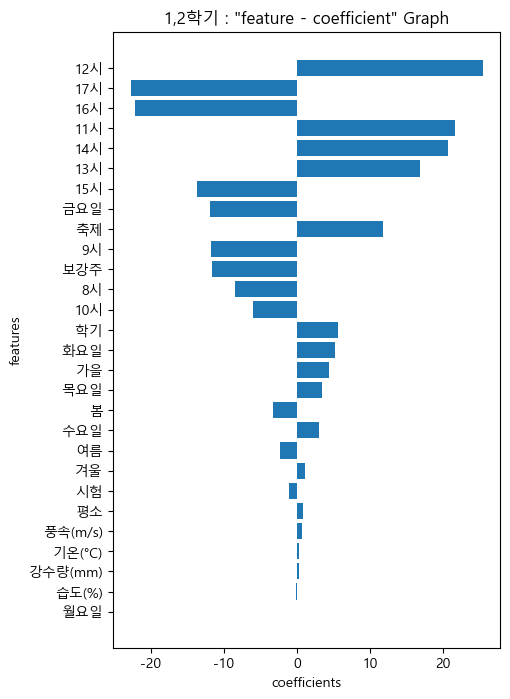

In [18]:
### coefficients 를 시각화

### figure size
plt.figure(figsize=(5, 8))

### bar plot : matplotlib.pyplot 모듈의 barh() 함수를 사용해서 수평 막대 그래프를 그림
plt.barh(coefs['feature'], coefs['coefficients'])
plt.title('1,2학기 : "feature - coefficient" Graph')
plt.xlabel('coefficients')
plt.ylabel('features')

# 파일로 저장
plt.savefig('../visualization/png/reg_feature_coef_full.png', dpi=300)

plt.show()

2. 모델이 **general**한지 알아보기 위해 **K-Fold Cross Validation**을 진행

In [19]:
# K-Fold Cross Validation 설정
# 5겹으로 진행
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lr = LinearRegression()


# 교차 검증을 통한 모델 학습 및 평가
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=kf)
mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=kf)
mae_scores = cross_val_score(lr, X, y, scoring='neg_mean_absolute_error', cv=kf)


# 평균 성능 지표 계산
aver_r2 = r2_scores.mean()     # 평균 R2 값 계산

mse = np.mean(np.abs(mse_scores))  # 평균 MSE 값 계산
rmse = np.sqrt(mse)  # RMSE 값 계산

mae = np.mean(np.abs(mae_scores))  # 평균 MAE 값 계산


# 결과 출력
print("Average R² Score:", aver_r2)
print("Average MSE:", mse)
print("Average RMSE:", rmse)
print("Average MAE:", mae)

Average R² Score: 0.725624357543898
Average MSE: 161.8709604394451
Average RMSE: 12.7228518988254
Average MAE: 9.582420090440278


3. 각 **변수가 유효**한지 확인을 위해, 통계 라이브러리 선형회귀를 돌려 **OLS Summary** 호출
* R-Squared, t value 확인

In [20]:
import statsmodels.api as sm

X_train2 = sm.add_constant(train_input) # formatting
### 회귀분석모형 수식을 간단하게 만들기 위해 다음과 같이 상수항을 독립변수 데이터에 추가하는 것을 상수항 결합(bias augmentation)작업이라고 함

### ordinary least square 의 약자로, 거리의 최소값을 기준으로 구하는 함수
### 상수항이 추가된 독립변수와 그에 대한 y 값으로 학습함
model2 = sm.OLS(train_target, X_train2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     합계   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     136.6
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          1.55e-300
Time:                        20:50:27   Log-Likelihood:                -4344.1
No. Observations:                1107   AIC:                             8736.
Df Residuals:                    1083   BIC:                             8856.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1466      0.735     12.446      0.000       7.705      10.589
학기            12.4663      0.514     24.230      0.000      11.457      13.476
8시            -7.5453      1.367     -5.521      0.000     -10.227      -4.864
9시           -10.8075      1.217     -8.881      0.000     -13.195      -8.420
10시           -5.1090      1.164     -4.391      0.000      -7.392      -2.826
11시           22.5373      1.118     20.158      0.000      20.344      24.731
12시           26.3618      1.131     23.311      0.000      24.143      28.581
13시           17.7852      1.134     15.685      0.000      15.560      20.010
14시           21.5753      1.142     18.887      0.000      19.334      23.817
15시          -12.6708      1.179    -10.746      0.000     -14.984     -10.357
16시          -21.1567      1.139    -18.578      0.000     -23.391     -18.922
17시          -21.8237      1.131    -19.292      0.000     -24.043     -19.604
봄              2.4178      0.708      3.413      0.001       1.028       3.808
여름             3.4091      1.045      3.262      0.001       1.359       5.459
가을             3.3069      0.632      5.235      0.000       2.067       4.546
겨울             0.0128      0.884      0.015      0.988      -1.722       1.747
보강주           -9.2996      1.651     -5.634      0.000     -12.538      -6.061
시험             1.2503      1.070      1.168      0.243      -0.849       3.350
축제            14.0633      1.585      8.870      0.000      10.952      17.174
평소             3.1326      0.866      3.619      0.000       1.434       4.831
월요일            1.7960      0.817      2.199      0.028       0.193       3.398
화요일            7.1275      0.751      9.489      0.000       5.654       8.601
수요일            4.8786      0.753      6.481      0.000       3.402       6.356
목요일            5.3451      0.747      7.154      0.000       3.879       6.811
금요일          -10.0006      0.778    -12.849      0.000     -11.528      -8.473
기온(°C)         0.3446      0.071      4.836      0.000       0.205       0.484
풍속(m/s)        0.7045      0.486      1.450      0.147      -0.249       1.658
강수량(mm)        0.2999      0.529      0.567      0.571      -0.738       1.337
습도(%)         -0.0832      0.025     -3.311      0.001      -0.133      -0.034
==============================================================================
Omnibus:                      211.730   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.072
Skew:                           0.794   Prob(JB):                    1.57e-228
Kurtosis:                       7.497   Cond. No.                     2.50e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

* 겨울, 풍속, 강수량이 t value가 0.05보다 높게 나옴.

In [21]:
# 모델 요약 결과를 문자열로 변환
summary_str = model2.summary().as_text()

# 문자열을 DataFrame으로 변환
summary_df = pd.DataFrame([summary_str.split('\n')])

# 엑셀 파일로 저장
summary_df.to_excel("../resource/reg_OLS/OLS_both.xlsx", index=False)

### 예측 결과 시각화 (test set)

In [20]:
### 예측 결과 시각화 (test set)
df = pd.DataFrame({'actual': test_target, 'prediction': pred_test})
df = df.sort_values(by='actual').reset_index(drop=True)
df.head()

,actual,prediction
0,2,-7.187715
1,3,19.135064
2,3,16.416727
3,4,15.735016
4,4,11.948529


In [21]:
df.tail()

,actual,prediction
364,101,75.075302
365,102,63.567055
366,107,50.809536
367,110,61.124647
368,127,72.329545


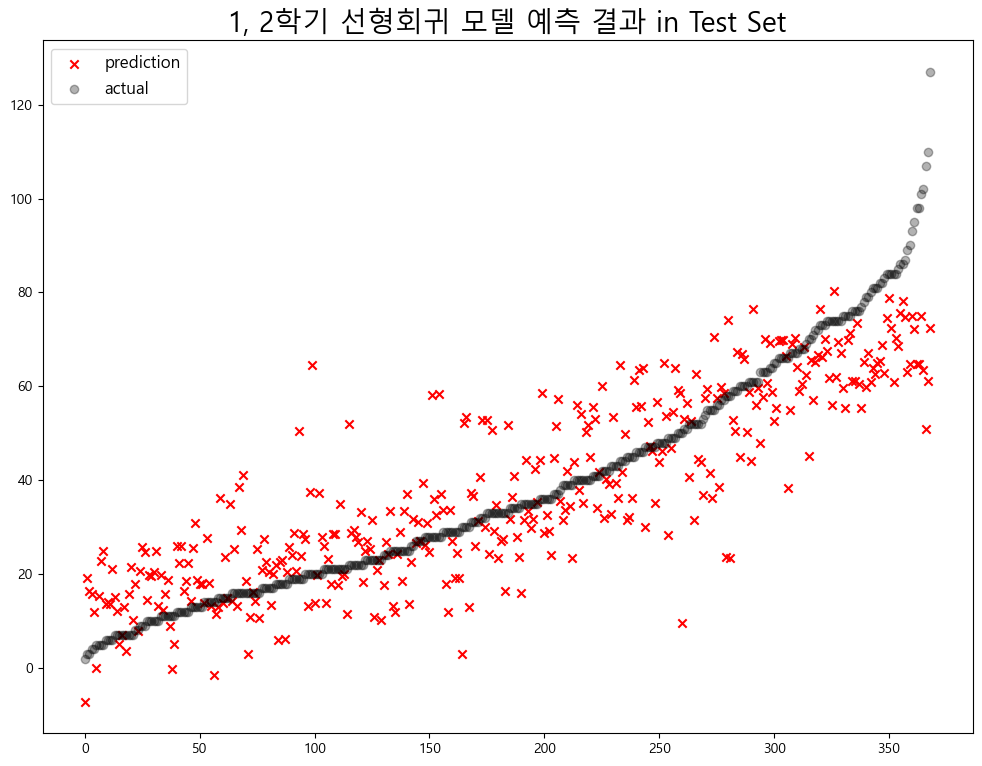

In [22]:
plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['prediction'], marker='x', color='r')
plt.scatter(df.index, df['actual'], alpha=0.3, marker='o', color='black')
plt.title("1, 2학기 선형회귀 모델 예측 결과 in Test Set", fontsize=20)
plt.legend(['prediction', 'actual'], fontsize=12)

# 파일로 저장
plt.savefig('../visualization/png/reg_pred_both.png', dpi=300)

plt.show()

### 학습시킨 모델 저장

In [30]:
# 모델 저장
with open('../run/model_load/reg_full.pkl', 'wb') as file:
    pickle.dump(lr, file)